In [1]:
pip install raidionicsmaps@git+https://github.com/raidionics/raidionics_maps.git@master#raidionicsmaps

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Download the test data
import os
import requests
import zipfile

test_data_url = 'https://github.com/raidionics/Raidionics-models/releases/download/1.2.0/Samples-RaidionicsMaps-UnitTest1.zip'

test_dir = os.path.join(os.getcwd(), 'unit_tests_results_dir')
os.makedirs(test_dir, exist_ok=True)

archive_dl_dest = os.path.join(test_dir, 'unittest1_data.zip')
if not os.path.exists(archive_dl_dest):
    headers = {}
    response = requests.get(test_data_url, headers=headers, stream=True)
    response.raise_for_status()
    if response.status_code == requests.codes.ok:
        with open(archive_dl_dest, "wb") as f:
            for chunk in response.iter_content(chunk_size=1048576):
                f.write(chunk)
    with zipfile.ZipFile(archive_dl_dest, 'r') as zip_ref:
        zip_ref.extractall(test_dir)

assert(os.path.exists(os.path.join(test_dir, 'Cohort_UnitTest1')))
print("Downloaded data available in {}".format(os.path.join(test_dir, 'Cohort_UnitTest1')))

Downloaded data available in /home/dbouget/Code/Private/raidionics_maps/notebooks/unit_tests_results_dir/Cohort_UnitTest1


In [3]:
import configparser
import os
import warnings
import logging

# Ignore all warnings
warnings.filterwarnings("ignore")
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

test_dir = os.path.join(os.getcwd(), 'unit_tests_results_dir')

test_config = configparser.ConfigParser()
test_config.add_section('Default')
test_config.set('Default', 'task', 'heatmap')
test_config.set('Default', 'input_folder', os.path.join(test_dir, 'Cohort_UnitTest1'))
test_config.set('Default', 'output_folder', os.path.join(test_dir, 'Cohort_UnitTest1_Output'))
test_config.add_section('Maps')
test_config.set('Maps', 'gt_files_suffix', 'label_tumor.nii.gz')
test_config.set('Maps', 'sequence_type', 'T1-CE')
test_config.set('Maps', 'use_registered_data', 'true')
test_config.set('Maps', 'extra_parameters_filename', os.path.join(test_dir, 'Cohort_UnitTest1', 'patients_parameters.csv'))
test_config.set('Maps', 'distribution_dense_parameters', 'Age,40')
test_config.set('Maps', 'distribution_categorical_parameters', 'Gender,')
test_config_filename = os.path.join(test_dir, 'unit_test_config.ini')
with open(test_config_filename, 'w') as outfile:
    test_config.write(outfile)

print("Running the heatmap generation unit test.\n")
from raidionicsmaps.compute import compute
compute(test_config_filename)

Running the heatmap generation unit test.



INFO:root:Computing location heatmap for the complete cohort!
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:root:Collecting data in memory...
100%|████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.98it/s]
INFO:root:Writing heatmaps to disk
INFO:root:Computed heatmap location with 20 samples.
INFO:root:Computing location heatmap for patients with Age under 40.0
pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:nibabel.global:pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
INFO:root:Collecting data in memory...
100%|████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  8.01it/s]
INFO:root:Writing heatmaps to disk
INFO:root:Computed heatmap location with 5 samples.
INFO:root:Computing location heatmap for patients with Age over 40.0
pixdim[0] (qfac) should be 1 (default) or -1; 

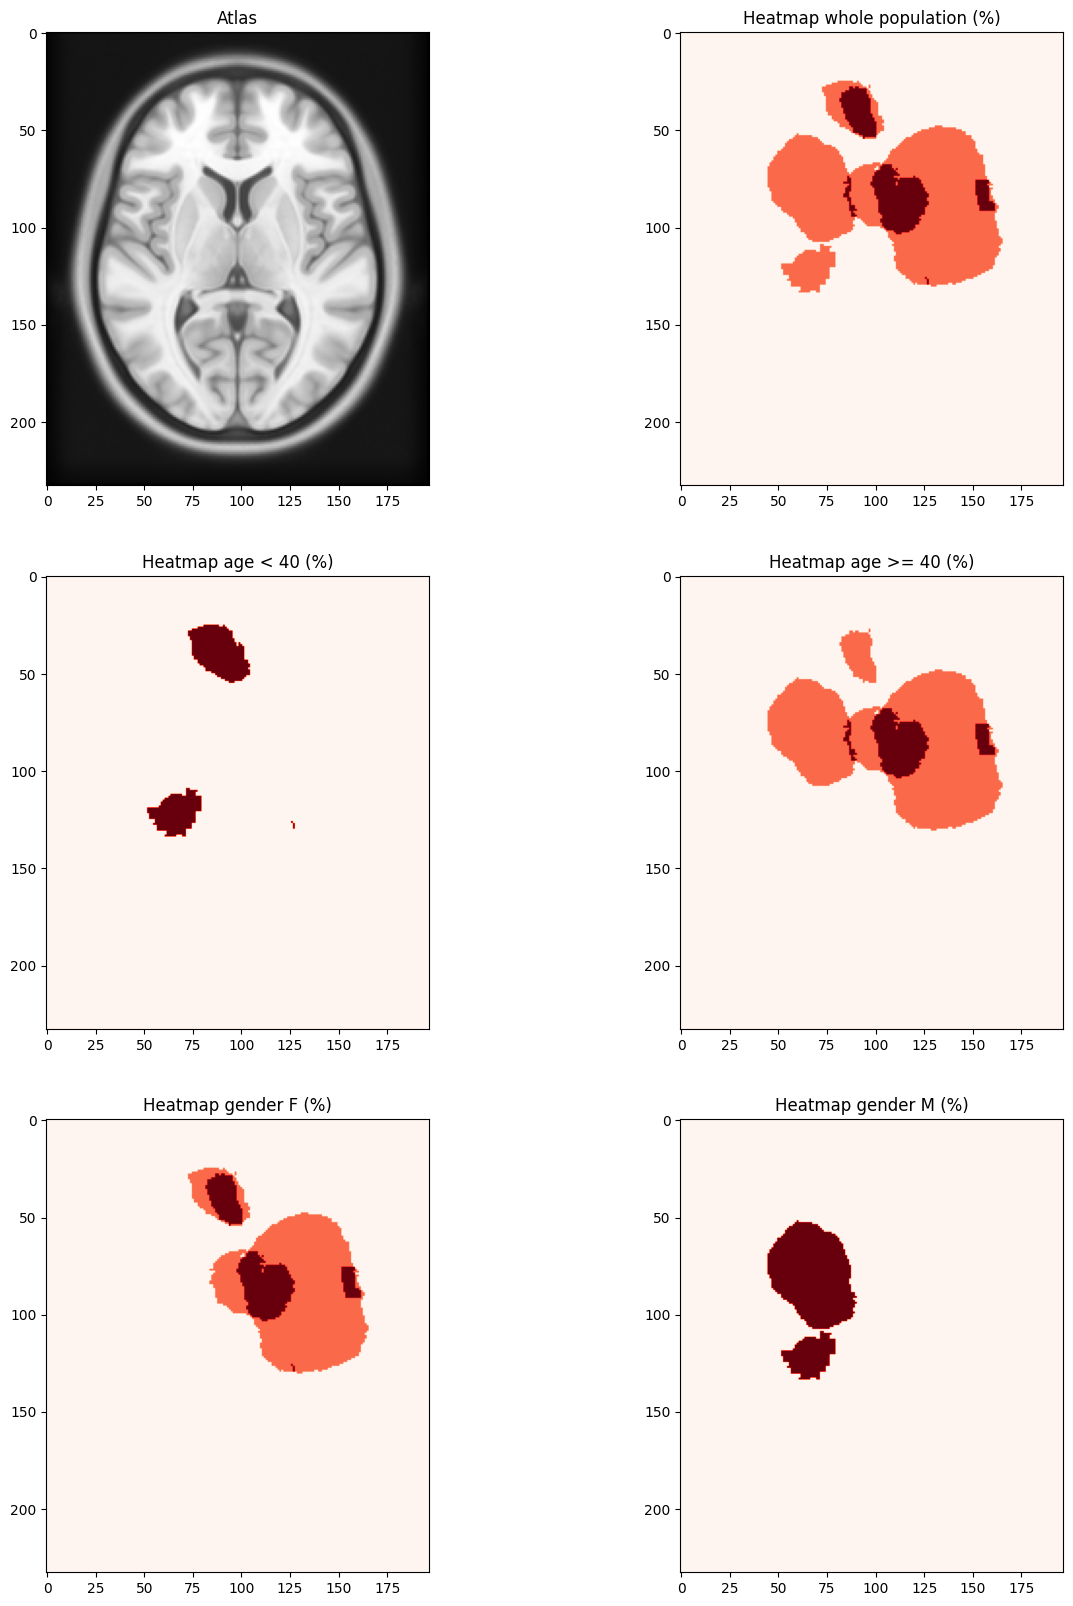

In [4]:
# Inspecting the results
import os
import nibabel as nib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

logging.getLogger().setLevel(logging.WARNING)

# Collecting the generated heatmap
atlas_filename = os.path.join(os.getcwd(), '..', 'raidionicsmaps', 'Atlases', 'mni_icbm152_nlin_sym_09a', 'mni_icbm152_t1_tal_nlin_sym_09a.nii')
heatmap_perc_filename = os.path.join(test_dir, 'Cohort_UnitTest1_Output', 'Heatmaps', 'Overall', 'heatmap_percentages.nii.gz')
heatmap_perc_ageup_filename = os.path.join(test_dir, 'Cohort_UnitTest1_Output', 'Heatmaps', 'Population_Age>=40.0', 'heatmap_percentages_Age>=40.0.nii.gz')
heatmap_perc_agedown_filename = os.path.join(test_dir, 'Cohort_UnitTest1_Output', 'Heatmaps', 'Population_Age<40.0', 'heatmap_percentages_Age<40.0.nii.gz')
heatmap_perc_genderf_filename = os.path.join(test_dir, 'Cohort_UnitTest1_Output', 'Heatmaps', 'Population_Gender-F', 'heatmap_percentages_Gender-F.nii.gz')
heatmap_perc_genderm_filename = os.path.join(test_dir, 'Cohort_UnitTest1_Output', 'Heatmaps', 'Population_Gender-M', 'heatmap_percentages_Gender-M.nii.gz')

# Loading the generated heatmap
atlas_nib = nib.load(atlas_filename)
heatmap_nib = nib.load(heatmap_perc_filename)
heatmap_ageup_nib = nib.load(heatmap_perc_ageup_filename)
heatmap_agedown_nib = nib.load(heatmap_perc_agedown_filename)
heatmap_genderf_nib = nib.load(heatmap_perc_genderf_filename)
heatmap_genderm_nib = nib.load(heatmap_perc_genderm_filename)

atlas = atlas_nib.get_fdata()[:]
heatmap = heatmap_nib.get_fdata()[:]
heatmap_ageup = heatmap_ageup_nib.get_fdata()[:]
heatmap_agedown = heatmap_agedown_nib.get_fdata()[:]
heatmap_genderf = heatmap_genderf_nib.get_fdata()[:]
heatmap_genderm = heatmap_genderm_nib.get_fdata()[:]

# Plotting the heatmap for a single 2D slice
cmap = matplotlib.colors.ListedColormap(mcolors.CSS4_COLORS)

fig, ax = plt.subplots(3, 2, figsize=(15, 20))
ax[0, 0].imshow(np.rot90(atlas[:, :, 79]), cmap="gray")
ax[0, 1].imshow(np.rot90(heatmap[:, :, 79]), cmap="Reds")
ax[1, 0].imshow(np.rot90(heatmap_agedown[:, :, 79]), cmap="Reds")
ax[1, 1].imshow(np.rot90(heatmap_ageup[:, :, 79]), cmap="Reds")
ax[2, 0].imshow(np.rot90(heatmap_genderf[:, :, 79]), cmap="Reds")
ax[2, 1].imshow(np.rot90(heatmap_genderm[:, :, 79]), cmap="Reds")

for i, title in enumerate(["Atlas", "Heatmap whole population (%)", "Heatmap age < 40 (%)", "Heatmap age >= 40 (%)", "Heatmap gender F (%)", "Heatmap gender M (%)"]):
  ax[int(i/2), i%2].set_title(title)
plt.show()